In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from lightgbm import LGBMRegressor

#read in data
data = pd.read_csv('/kaggle/input/vancouver-cars-cleaned/cars_cleaned.csv')

#### missing values #####
data.dropna(inplace=True)#there are only a few dozen missing values so drop those rows

#cleaning
data = data[data.odometer<1e6] #drop rows where the odometer is very high
data = data[data.price<1e5] #drop rows where the price is very high
#drop unneeded columns
data.drop(['year', 'model', 'latitude', 'longitude', 'pos_words', 'neg_words', 'low_text', 'location', 'model1', 'model2', 'model0', 'location_simple'], axis=1, inplace=True)

#only consider the top 12 makes
top_makes = data.make_.value_counts()[:15].index
data = data[data['make_'].isin(top_makes)]

#get rid of negative age values (for model years that are in the future)
data['age'] = data['age'].map(lambda x: x if x>=0 else 0)

#add yes or no columns
data['4wd'] = data['drive'].map(lambda x: 1 if x==' 4wd' else 0)
data['diesel'] = data['fuel'].map(lambda x: 1 if x==' diesel' else 0)
data['electric'] = data['fuel'].map(lambda x: 1 if x==' electric' else 0)
data['hybrid'] = data['fuel'].map(lambda x: 1 if x==' hybrid' else 0)
data['clean title'] = data['title status'].map(lambda x: 1 if x==' clean' else 0)
data['new'] = data['condition'].map(lambda x: 1 if x==' new' else 0)
data['manual transmission'] = data['transmission'].map(lambda x: 1 if x==' manual' else 0)
data['sale by owner'] = data['sale type'].map(lambda x: 1 if x=='owner' else 0)
data['type'] = data['type'].replace(['unknown', ' other'], value='unknown/other').replace(' offroad', value=' truck')

#label encode the size column
size_lib = {' sub-compact':0, ' compact':1, ' mid-size':2, ' full-size':3 , 'unknown':np.nan}
data['size'] = data['size'].replace(size_lib)

#convert cylinders to number
def get_cyls(s):
    try:
        x = s.split(' ')[1]
        if x == 'other':
            return(np.nan)
        else:
            return(x)
    except:
        return(np.nan)
data['cylinders'] = data['cylinders'].map(get_cyls)

#drop excell columns
data.drop(['fuel', 'title status', 'transmission', 'condition', 'drive', 'sale type'], axis=1, inplace=True)

data.head()

,odometer,paint color,price,type,cylinders,size,age,make_,4wd,diesel,electric,hybrid,clean title,new,manual transmission,sale by owner
0,281000,white,5500,SUV,4,2.0,14,bmw,1,0,0,0,0,0,0,1
1,140000,unknown,600,sedan,4,2.0,37,honda,0,0,0,0,1,0,0,1
2,110000,white,67000,truck,8,NaN,13,gmc,0,1,0,0,1,0,0,1
5,300000,unknown,3800,sedan,6,2.0,19,bmw,1,0,0,0,1,0,0,1
7,197000,blue,2800,sedan,4,3.0,16,nissan,0,0,0,0,1,0,0,1


In [2]:
#### create training and validation data ####
X = data.copy()
y = X.pop('price')

#### pipeline ###
cat_cols = ['paint color', 'type', 'make_'] #categorical columns
numeric_cols = [col for col in X.columns if col not in cat_cols] #the rest are numeric

# Preprocessing for categorical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), 
    ('num_standardizer', StandardScaler(with_mean=False))])
categorical_transformer = Pipeline(steps=[
    ('cat_encoder', OneHotEncoder(handle_unknown='ignore')), 
    ('cat_standardizer', StandardScaler(with_mean=False))
    ])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric_cols),
        ('cat', categorical_transformer, cat_cols)])

def unit(x): #unit transformation
    return(x)

model = TransformedTargetRegressor(
        regressor=Lasso(alpha=250, max_iter=1e5, tol=1e-12), 
        func=unit,#np.log10,
        inverse_func=unit,#sp.special.exp10
    )

# Bundle preprocessing and modeling code in a pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

#cross validation
scores = cross_val_score(pipeline, X, y, cv=5, scoring = 'neg_mean_absolute_error')
print('MAE (5-fold cross validation):', -scores.mean())

MAE (5-fold cross validation): 6714.204070982223


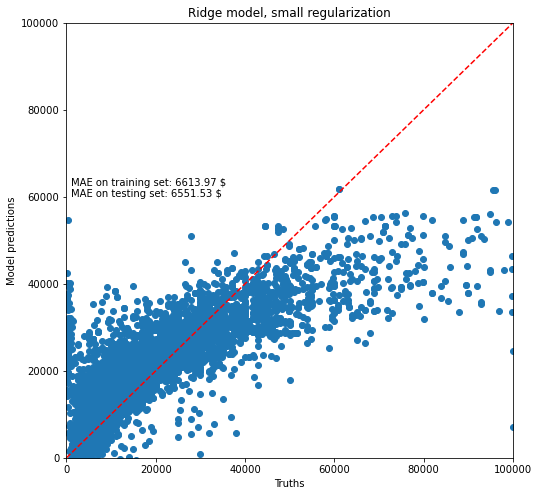

In [3]:
#https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html

from sklearn.metrics import median_absolute_error
import matplotlib.pyplot as plt

#split training and test data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=41)

#fit on training data
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_train)
mae = mean_absolute_error(y_train, y_pred)
string_score = f'MAE on training set: {mae:.2f} $'
y_pred = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
string_score += f'\nMAE on testing set: {mae:.2f} $'
fig, ax = plt.subplots(figsize=(8, 8))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")
plt.text(1000, 60000, string_score)
plt.title('Ridge model, small regularization')
plt.ylabel('Model predictions')
plt.xlabel('Truths')
plt.xlim([0, 1e5])
_ = plt.ylim([0, 1e5])

odometer shown for an increase of 25000
age shown for an increase of 5


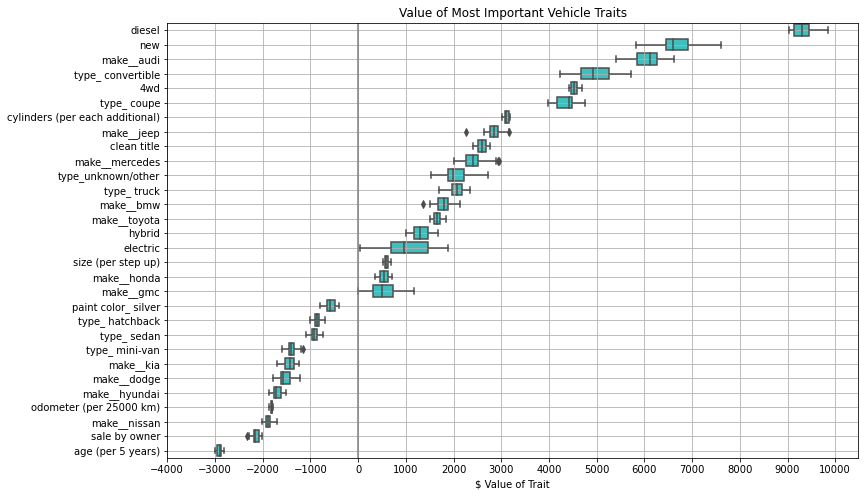

In [4]:
feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['cat_encoder'].get_feature_names(input_features=cat_cols)
feature_names = np.concatenate([numeric_cols, feature_names])

stds_cat = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['cat_standardizer'].scale_
stds_num = pipeline.named_steps['preprocessor'].named_transformers_['num'].named_steps['num_standardizer'].scale_
stds = np.concatenate([stds_num, stds_cat])

X_train_preprocessed = pd.DataFrame.sparse.from_spmatrix(
    pipeline.named_steps['preprocessor'].transform(X_train),
    columns=feature_names,
    )
devs = [1 for x in range(len(feature_names))] #plot each coefficient scaled by a feature change of 1
devs[0]= 25000 #5000 km for odometer we will plot for a change of 5000km
print(feature_names[0], 'shown for an increase of', devs[0])
devs[3]= 5 #years
print(feature_names[3], 'shown for an increase of', devs[3])

coefs = pd.DataFrame(
    pipeline.named_steps['model'].regressor_.coef_ * devs / stds,
    columns=['Coefficient importance'], index=feature_names
)

from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold

cv_model = cross_validate(
    pipeline, X, y, cv=RepeatedKFold(n_splits=5, n_repeats=5),
    return_estimator=True, n_jobs=-1
)
coefs = pd.DataFrame(
    [est.named_steps['model'].regressor_.coef_ / stds * devs
     for est in cv_model['estimator']],
    columns=feature_names
)

ordered_cols = coefs.mean(axis=0).sort_values(ascending=False).index
coefs_ordered = pd.DataFrame()

imp_coefs = abs(coefs.mean(axis=0))>500
imp_coefs = imp_coefs[imp_coefs.values==True]

for col in ordered_cols:
    if col in imp_coefs.index:
        coefs_ordered[col] = coefs[col]

coefs_ordered.rename(columns = {'odometer': 'odometer (per {} km)'.format(devs[0]),
                               'age': 'age (per {} years)'.format(devs[3]),
                               'cylinders': 'cylinders (per each additional)'.format(devs[3]),
                               'size': 'size (per step up)'},
                    inplace=True)        

plt.figure(figsize=(16, 8))
#sns.stripplot(data=coefs_ordered, orient='h', color='k', alpha=0.5)
sns.boxplot(data=coefs_ordered, orient='h', color='cyan', saturation=0.5)
plt.axvline(x=0, color='.5')
plt.xlabel('$ Value of Trait')
plt.title('Value of Most Important Vehicle Traits')
plt.subplots_adjust(left=.3)
plt.xticks(range(-4000, 11000, 1000))
plt.grid()

The top 12 most popular brans were considered in this linear analysis. They are (in order of popuularity): Ford, Toyota, Honda, Chevrolet, Mazda, Nissan, Dodge, BMW, Hyundai, Volkswagen, Mercedes, Kia, Jeep, Audi, and GMC.

This plot displays the linear coefficients of the linear model, and can be used to get an idea of the value of each trait. Keep in mind that the linear model is not particularly accurate, but it does capture the general trend of the data.

Values shown are averages over 5 cross-validation data sets repeated 5 times for a total of 25 models. The error bars show the extend of the data with outliers shown as separate dots.

Most traits are 'yes/no'. The exceptions are cyilnders (\\$ per cylinder), age (\\$ per 5 years), odometer (\\$ per 25,000 km), and size (\\$ per step up between: sub-compact, compact, mid-size, full-size)

Note that Tesla was not included as it is a high-end band. When added to the plot above, it has a value trait of around $25,000, similar to porsche

<AxesSubplot:>

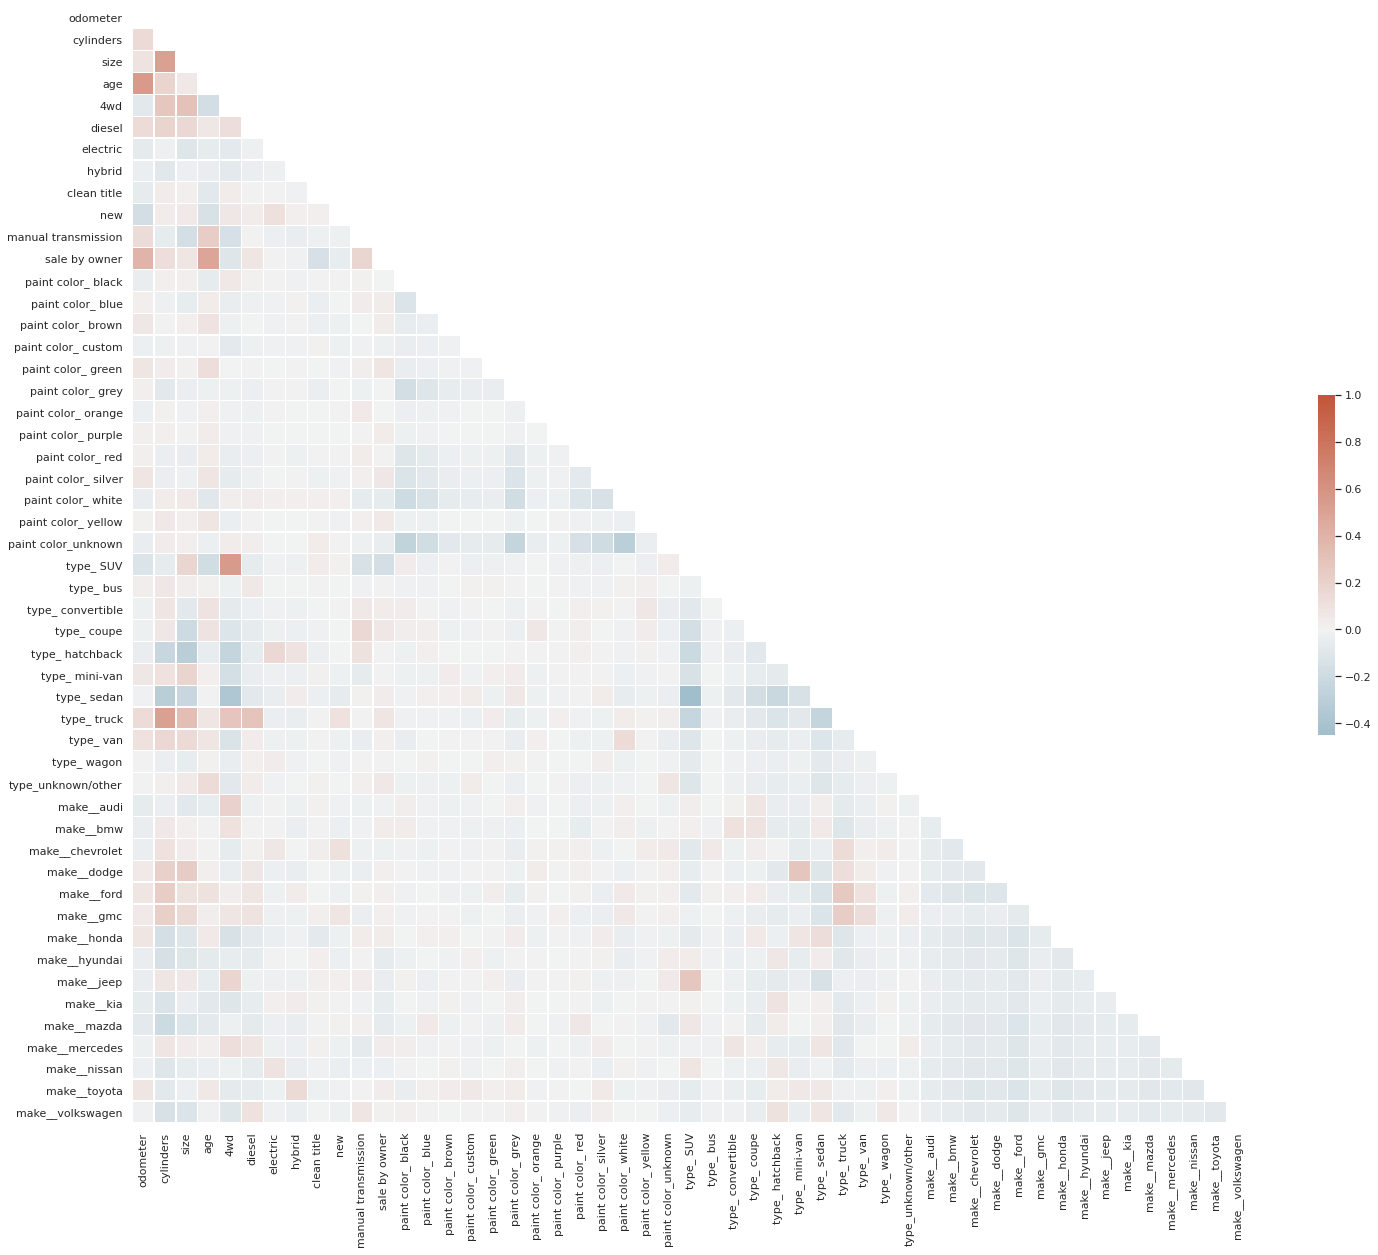

In [5]:
from string import ascii_letters
sns.set_theme(style="white")

# Compute the correlation matrix
corr = X_train_preprocessed.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 25))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.25, cbar_kws={"shrink": .25}, xticklabels = X_train_preprocessed.columns, yticklabels = X_train_preprocessed.columns)

RMSE: 6841.347709800611
MAE: 3443.731842922603

In [6]:
# model = LGBMRegressor(num_leaves = 300,
#                       min_child_samples=1,
#                       random_state = 0,
#                      )